Using device: cuda
Loading splits...
Train: 560 | Val: 70 | Test: 70
Train batches: 140 | Val batches: 18
Model created. Parameters: 120835


Epoch 1/10 Train: 100%|██████████| 140/140 [00:23<00:00,  5.96it/s]


Epoch 1/10 | Train loss: 0.016015 | Val loss: 0.010668
Best model saved (val loss: 0.010668)


Epoch 2/10 Train: 100%|██████████| 140/140 [00:23<00:00,  5.87it/s]


Epoch 2/10 | Train loss: 0.009793 | Val loss: 0.010235
Best model saved (val loss: 0.010235)


Epoch 3/10 Train: 100%|██████████| 140/140 [00:23<00:00,  6.00it/s]


Epoch 3/10 | Train loss: 0.008826 | Val loss: 0.009115
Best model saved (val loss: 0.009115)


Epoch 4/10 Train: 100%|██████████| 140/140 [00:23<00:00,  6.00it/s]


Epoch 4/10 | Train loss: 0.008664 | Val loss: 0.008817
Best model saved (val loss: 0.008817)


Epoch 5/10 Train: 100%|██████████| 140/140 [00:23<00:00,  6.01it/s]


Epoch 5/10 | Train loss: 0.008638 | Val loss: 0.008689
Best model saved (val loss: 0.008689)


Epoch 6/10 Train: 100%|██████████| 140/140 [00:23<00:00,  5.95it/s]


Epoch 6/10 | Train loss: 0.008438 | Val loss: 0.008392
Best model saved (val loss: 0.008392)


Epoch 7/10 Train: 100%|██████████| 140/140 [00:23<00:00,  5.94it/s]


Epoch 7/10 | Train loss: 0.008095 | Val loss: 0.008980


Epoch 8/10 Train: 100%|██████████| 140/140 [00:23<00:00,  5.98it/s]


Epoch 8/10 | Train loss: 0.007776 | Val loss: 0.008892


Epoch 9/10 Train: 100%|██████████| 140/140 [00:23<00:00,  6.01it/s]


Epoch 9/10 | Train loss: 0.008108 | Val loss: 0.008490


Epoch 10/10 Train: 100%|██████████| 140/140 [00:23<00:00,  6.04it/s]


Epoch 10/10 | Train loss: 0.007861 | Val loss: 0.007162
Best model saved (val loss: 0.007162)


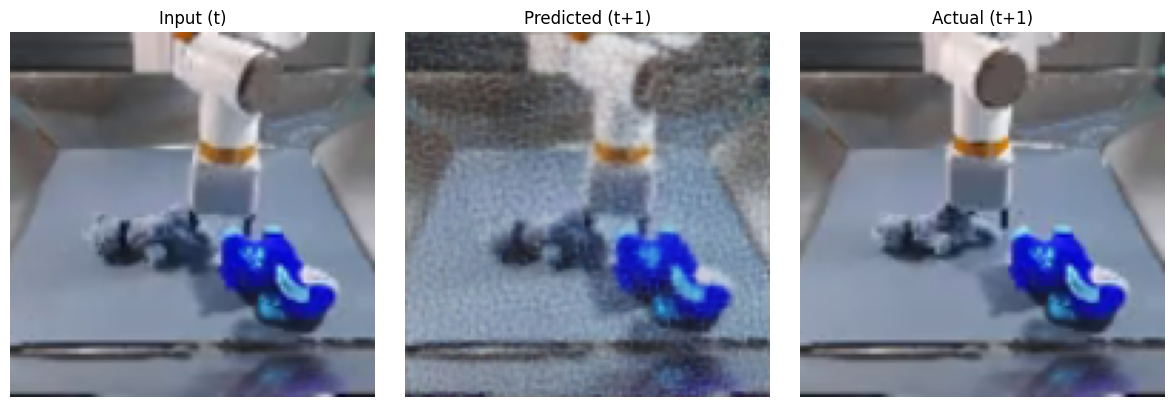

Training finished. Check 'checkpoints/simple_recon_best.pth' for best model.


In [29]:
# 02_simple_reconstruction_training.ipynb
# =======================================
# Simple next-frame reconstruction training
# Predicts frame t+1 from frame t + action t
# Uses RoboNetDataset from models/data_loader.py

# ────────────────────────────────────────────────
# 1. Imports & Configuration
# ────────────────────────────────────────────────

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Import your dataset class
from models.data_loader import RoboNetDataset

# Paths (adjust if different)
PROJECT_ROOT = r"E:\NVIDIA_PROJECTS\Neural-World-Model-for-Embodied-AI-Robotics"
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "raw", "robonet", "hdf5")
SPLITS_PATH = os.path.join(PROJECT_ROOT, "data", "splits.json")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 4
NUM_WORKERS = 0          # 0 is safer on Windows
EPOCHS = 10
LR = 1e-3
SEQ_LEN = 15             # predict from middle of sequence

# ────────────────────────────────────────────────
# 2. Load saved splits
# ────────────────────────────────────────────────

print("Loading splits...")
with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)

train_files = splits["train"]
val_files   = splits["val"]
test_files  = splits["test"]

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# ────────────────────────────────────────────────
# 3. Create Datasets & DataLoaders
# ────────────────────────────────────────────────

train_dataset = RoboNetDataset(
    file_list=train_files,
    data_root=DATA_ROOT,
    camera_idx=0,
    resize_to=(128, 128),
    seq_len=SEQ_LEN
)

val_dataset = RoboNetDataset(
    file_list=val_files,
    data_root=DATA_ROOT,
    camera_idx=0,
    resize_to=(128, 128),
    seq_len=SEQ_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# ────────────────────────────────────────────────
# 4. Simple Model: Predict next frame
# ────────────────────────────────────────────────

class SimpleFramePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.Sigmoid()
        )
        self.action_fc = nn.Linear(4, 128 * 128)  # embed action to spatial map

    def forward(self, current_frame, action):
        # current_frame: (B, 3, H, W)
        # action: (B, 4)
        act_emb = self.action_fc(action).view(-1, 1, 128, 128)
        x = current_frame + act_emb
        return self.conv(x)


model = SimpleFramePredictor().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

print("Model created. Parameters:", sum(p.numel() for p in model.parameters()))

# ────────────────────────────────────────────────
# 5. Training Loop with Validation
# ────────────────────────────────────────────────

best_val_loss = float('inf')
checkpoint_path = os.path.join(CHECKPOINT_DIR, "simple_recon_best.pth")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    num_batches = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Train"):
        frames = batch['frames'].to(DEVICE)    # (B, seq_len, 3, 128, 128)
        actions = batch['actions'].to(DEVICE)  # (B, seq_len-1, 4)

        # Predict middle transition (t → t+1)
        t = SEQ_LEN // 2
        current = frames[:, t]
        action = actions[:, t]
        target = frames[:, t+1]

        pred = model(current, action)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    avg_train_loss = train_loss / num_batches

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            frames = batch['frames'].to(DEVICE)
            actions = batch['actions'].to(DEVICE)
            current = frames[:, t]
            action = actions[:, t]
            target = frames[:, t+1]

            pred = model(current, action)
            val_loss += criterion(pred, target).item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train loss: {avg_train_loss:.6f} | Val loss: {avg_val_loss:.6f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved (val loss: {best_val_loss:.6f})")

# ────────────────────────────────────────────────
# 6. Visualize Predictions
# ────────────────────────────────────────────────

model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    frames = batch['frames'].to(DEVICE)
    actions = batch['actions'].to(DEVICE)

    t = SEQ_LEN // 2
    current = frames[0:1, t]          # take first sample
    action = actions[0:1, t]
    target = frames[0:1, t+1]

    pred = model(current, action)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(current[0].cpu().permute(1, 2, 0).numpy())
    axes[0].set_title("Input (t)")
    axes[1].imshow(pred[0].cpu().permute(1, 2, 0).numpy())
    axes[1].set_title("Predicted (t+1)")
    axes[2].imshow(target[0].cpu().permute(1, 2, 0).numpy())
    axes[2].set_title("Actual (t+1)")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Training finished. Check 'checkpoints/simple_recon_best.pth' for best model.")